# SO/PHI -FDT and SDO/HMI cross-comparison tutorial

## Additional material of the paper: "Comparison of magnetic data products from Solar Orbiter SO/PHI-FDT and SDO/HMI"

### Author: Alejandro Moreno Vacas (amoreno@iaa.es; PhD Student at Instituto de Astrofísica de Andalucía, Granada, Spain)

We are presenting a tutorial comparing data from the Full Disc Telescope of SO/PHI and SDO/HMI (RTE Inversion Products). The comparison presented is a preliminary one, just using Sunpy and Python routines. A comparison for the Line-of-Sight Magnetic Field component is presented. Data needed for this tutorial is available at "./data_tutorial_dir/". In case extra data presented in the paper are needed contact the author.

In [286]:
#We include the libraries needed

import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import sunpy.map
import reproject
from astropy.io import fits
from matplotlib.widgets import Slider
from scipy.optimize import curve_fit
import math
from ipywidgets import interact, widgets

In [287]:
%matplotlib inline

### Loading data

In [288]:
#We define the data_dir pathing
data_dir = "/home/amoreno/Dropbox/Doctorado/AlignmentHMI-FDT/Data/HMI_ME_720s/"
data_dir_phi = "/home/amoreno/Escritorio/comparisonnewdata/v4-infconj/"

#For HMI we are using the Vector products, so we calculate the BLoS as B*cos(gamma). B is field strenght and gamma inclination. 
hmi_mag_path = data_dir + "hmi.ME_720s_fd10.20220308_070000_TAI.field.fits"
hmi_inc_path = data_dir + "hmi.ME_720s_fd10.20220308_070000_TAI.inclination.fits" 

hmi_mag_data, hmi_header = fits.getdata(hmi_mag_path, header = True)
hmi_inc_data = fits.getdata(hmi_inc_path, header = False) #The header is the same, we do not need to read it again
hmi_data = hmi_mag_data * np.cos(np.deg2rad(hmi_inc_data))

#For FDT we have already this BLoS calculated.
path_data_phi = data_dir_phi + "/solo_L2_phi-fdt-blos_20220308T070009_V202308032203_0243080501.fits"  

data_phi, header_phi = fits.getdata(path_data_phi, header = True)

#Now we define the sunpy maps for HMI and FDT. We need to use .rotate() so that the solar north points upwards

hmi_blos_map = sunpy.map.Map(hmi_data, hmi_header).rotate(recenter = True, missing = np.nan)
fdt_blos_map = sunpy.map.Map(data_phi, header_phi).rotate(recenter = True, missing = np.nan)


### Plotting data

In [289]:
#plotting details
hmi_blos_map.plot_settings['norm'].vmin = -100
hmi_blos_map.plot_settings['norm'].vmax = 100 
hmi_blos_map.plot_settings['cmap'] = "Greys_r"

fdt_blos_map.plot_settings['norm'].vmin = -100
fdt_blos_map.plot_settings['norm'].vmax = 100
fdt_blos_map.plot_settings['cmap'] = "Greys_r"

(460.0, 1700.0)

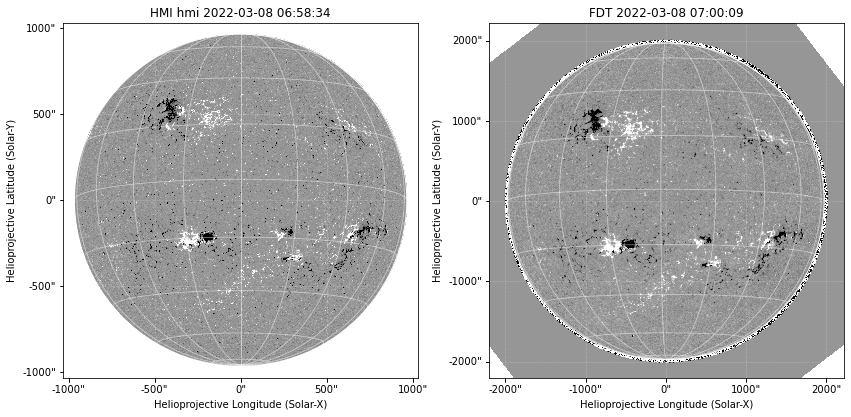

In [290]:
#We plot both maps. The size of the solar disc is different due to the different distance of SDO and Solar Orbiter.
#This size is almost double in FDT because the distance to the Sun of the dataset is about 0.485 AU

fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_blos_map)

hmi_blos_map.plot(axes=ax1)



ax2 = fig.add_subplot(122, projection=fdt_blos_map)

fdt_blos_map.plot(axes=ax2)

fdt_blos_map.draw_limb()
fdt_blos_map.draw_grid(grid_spacing = 20 * u.deg)

ax2.set_xlim(460,1700)
ax2.set_ylim(460,1700)


### Reprojecting FDT onto HMI's FoV

We use the reprojection algorithm present in sunpy, which uses the WCS information within the header of the FITS file, to remap FDT onto the HMI's FOV.

First, we create an out_header using sunpy.map.make_fitswcs_header to be the output of the FDT remapped image.

In [291]:
#Rotate FDT onto HMI plane

repro_header = sunpy.map.make_fitswcs_header(
    fdt_blos_map.data.shape,
    hmi_blos_map.reference_coordinate.replicate(rsun=fdt_blos_map.reference_coordinate.rsun),
    scale=u.Quantity(fdt_blos_map.scale),
    instrument="PHI",
    observatory="HMI Observer"
                                          )

Now we apply the reprojection algorithm. It can take some seconds to finish

In [292]:
fdt_reprojected_hmi = fdt_blos_map.reproject_to(repro_header, algorithm = "adaptive")


Now we plot the reprojected FDT map alongside the original HMI map. Despite the small angle between SDO and Solar Orbiter, the reprojected FDT image does not fill the full solar disk as seen on HMI (due to their different observation viewpoints).

(790.0, 1365.0)

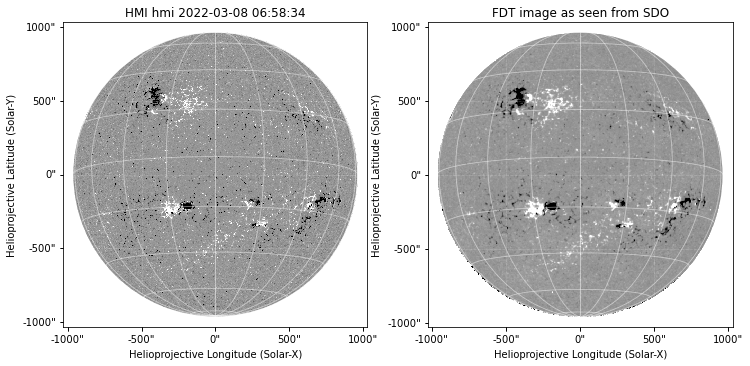

In [293]:
fig = plt.figure(figsize = (12,6))

ax1 = fig.add_subplot(121, projection= hmi_blos_map)

hmi_blos_map.plot(axes=ax1)

hmi_blos_map.draw_limb()
hmi_blos_map.draw_grid(grid_spacing = 20 * u.deg)

ax2 = fig.add_subplot(122, projection= fdt_reprojected_hmi)

fdt_reprojected_hmi.plot(axes=ax2, title='FDT image as seen from SDO', autoalign = True)

fdt_reprojected_hmi.draw_limb()
fdt_reprojected_hmi.draw_grid(grid_spacing = 20 * u.deg)

ax2.set_xlim(790,1365)
ax2.set_ylim(790,1365)


### Resampling HMI to FDT resolution

As presented in the paper, HMI's resolution is almost 7.5 larger than the one of FDT, so we need to downgrade the resolution of HMI to provide a one-to-one pixel comparison. For that purpose we use the routine resample of Sunpy.

First, we crop both maps to have a submap of each instrument with exactly the same axis limits. In this case, we will create submaps from -1000 to 1000 arcsec in X and Y axis


In [294]:
xmin, xmax = -1000, 1000
ymin, ymax = -1000, 1000

#First the HMI map
top_right_HMI = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hmi_blos_map.coordinate_frame)
bottom_left_HMI = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hmi_blos_map.coordinate_frame)

hmi_submap = hmi_blos_map.submap(bottom_left_HMI, top_right = top_right_HMI)

#Then the FDT map that previously we reprojected to HMI's FoV
top_right_FDT = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=fdt_reprojected_hmi.coordinate_frame)
bottom_left_FDT = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=fdt_reprojected_hmi.coordinate_frame)

fdt_reprojected_hmi_submap = fdt_reprojected_hmi.submap(bottom_left_FDT, top_right = top_right_FDT)

Now, we use the resample routine to make equal both resolutions

In [295]:



#Now we compare the axis and pixel size between both maps
print(np.shape(hmi_submap_resampled.data), np.shape(fdt_reprojected_hmi_submap.data))
print(hmi_submap_resampled.meta["CDELT1"], hmi_submap_resampled.meta["CDELT2"])
print(fdt_blos_map.meta["CDELT1"], fdt_blos_map.meta["CDELT2"])

(560, 560) (560, 560)
3.5732235889821427 3.5732235889821427
3.574 3.574


Now we define the four selected regions for our study (as presented on the paper)

In [296]:
#Write 1,2,3 or 4 for the selected area (as defined in paper). In this example
area = 1

if area == 1:

    ymin, ymax = -380, -85
    xmin, xmax = -400, -105
 
elif area == 2:

    ymin, ymax = -402, -105
    xmin, xmax = 125, 420

elif area == 3:

    ymin, ymax = -350, -55
    xmin, xmax = 582, 875

elif area == 4:
    
    ymin, ymax = 350, 645
    xmin, xmax = -552, -255

#Now we crop the maps to cut-out the selected area
    
top_right = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hmi_submap_resampled.coordinate_frame)
bottom_left = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hmi_submap_resampled.coordinate_frame)

hmi_area = hmi_submap_resampled.submap(bottom_left, top_right = top_right)

top_right = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=fdt_reprojected_hmi_submap.coordinate_frame)
bottom_left = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=fdt_reprojected_hmi_submap.coordinate_frame)

fdt_area = fdt_reprojected_hmi_submap.submap(bottom_left, top_right = top_right)

Now we plot one over the other to compare the pixel size and the alignment

In [297]:
#Create transparency slider

def plot_images_with_transparency(alpha):
    
    fig = plt.figure(figsize = (15,15))

    ax = fig.add_subplot(121, projection = hmi_area)
    
    ax.imshow(hmi_area.data, cmap='Greys_r', clim = (-100,100))
    ax.set_title('Imagen 1')
    #The transparency of the second image is tunable by the slider
    ax.imshow(fdt_area.data, cmap='Greys_r', alpha=alpha, clim = (-100,100))
 
    ax.set_ylabel('Helioprojective Latitude (Solar - Y)', fontsize = 11.5)
    ax.set_xlabel('Helioprojective Longitude (Solar - X)', fontsize = 11.5)

# Interactive slider
interact(plot_images_with_transparency, alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

0.9392847913832855


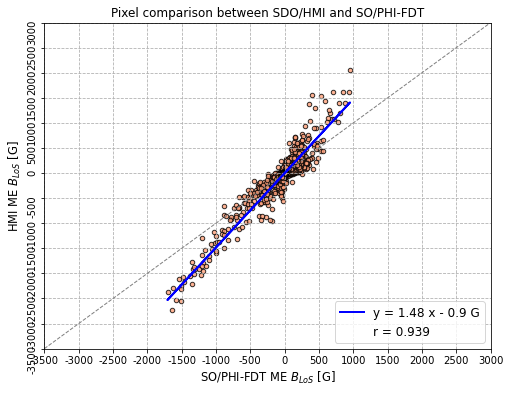

In [298]:
#Define the linear fit
def linear(x, a, b):
    return a * x + b

#Define function to round parameters by its errors
def round_by_err(x, x_err):
    round_to = -int(math.floor(math.log10(x_err)))
    x_err = round(x_err, round_to)
    x = round(x, round_to)
    if round_to == 0:
        x, x_err = int(x), int(x_err)
    return x, x_err



#We make both 2-D arrays flat  to have 1-D vector
x = fdt_area.data.flatten() 
y = hmi_area.data.flatten() 

fig = plt.figure(figsize = (8,6))

ax_scatter = fig.add_subplot(111)

ax_scatter.scatter(x, y, s = 20, edgecolors = 'k', color = "lightsalmon", alpha = 0.8)

ax_scatter.set_xticks(np.arange(-3500,3501,500))
ax_scatter.set_yticks(np.arange(-3500,3501,500))
ax_scatter.set_ylim([-3501, 3000])
ax_scatter.set_xlim([-3501, 3000])

ax_scatter.set_xticklabels(ax_scatter.get_xticks().astype(int), rotation = 0, fontsize = 10)  
ax_scatter.set_yticklabels(ax_scatter.get_yticks().astype(int), rotation = 90, fontsize = 10) 
ax_scatter.set_ylabel('HMI ME $B_{LoS}$ [G]', fontsize = 11.5)
ax_scatter.set_xlabel('SO/PHI-FDT ME $B_{LoS}$ [G]', fontsize = 11.5)

ax_scatter.grid(which = 'both', linestyle = 'dashed')
ax_scatter.set_title("Pixel comparison between SDO/HMI and SO/PHI-FDT")


################# FIT####################
####We calculate the linear fit parameters of HMI against FDT and then FDT againts HMI to average the slopes, as explained in the paper
pearson_coefficient = np.corrcoef(x,y)
print(pearson_coefficient[0,1])


popt, pcov = curve_fit(linear, x, y)
errors = [np.sqrt(pcov[i][i]) for i in range(0, len(pcov))]

alpha, alpha_err = round_by_err(popt[0], errors[0])
beta, beta_err = round_by_err(popt[1], errors[1])

popt_2, pcov_2 = curve_fit(linear, y, x)

errors_2 = [np.sqrt(pcov_2[i][i]) for i in range(0, len(pcov_2))]

alpha_2, alpha_err_2 = round_by_err(popt_2[0], errors_2[0])
beta_2, beta_err_2 = round_by_err(popt_2[1], errors_2[1])


x_lin = np.arange(-3500, 3500, 100)


mean = np.array([(alpha + 1/alpha_2)/2,(beta - beta_2)/2])

if beta - beta_2 >= 0:
    plt.plot(x, linear(x, *mean), color = "b", linewidth = 2, label = r"y = {} x + {} G".format(np.round(mean[0], 2), np.round(mean[1], 2)), zorder = 3)
    
else:
    plt.plot(x, linear(x, *mean), color = "b", linewidth = 2, label = r"y = {} x - {} G".format(np.round(mean[0], 2), np.abs(np.round(mean[1], 2))), zorder = 3)

plt.plot([], [], ' ', label="r = %.3f" % (pearson_coefficient[0,1]))
# plt.plot([], [], ' ', label="y = %.2f·x + %.2f" % (mean[0], mean[1]))
plt.plot(x_lin, x_lin, color = "grey", linestyle = "dashed", linewidth = 1)#, label = "y = x")
plt.legend(loc = "lower right", fontsize = 12)